In [1]:
import torch

print("Number of GPU: ", torch.cuda.device_count())
print("GPU Name: ", torch.cuda.get_device_name())


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Number of GPU:  1
GPU Name:  NVIDIA GeForce RTX 3050 6GB Laptop GPU
Using device: cuda


Image batch size: torch.Size([128, 3, 28, 28])


100%|██████████████████████████████████████████████████████████████████████████████| 200/200 [1:54:40<00:00, 34.40s/it]


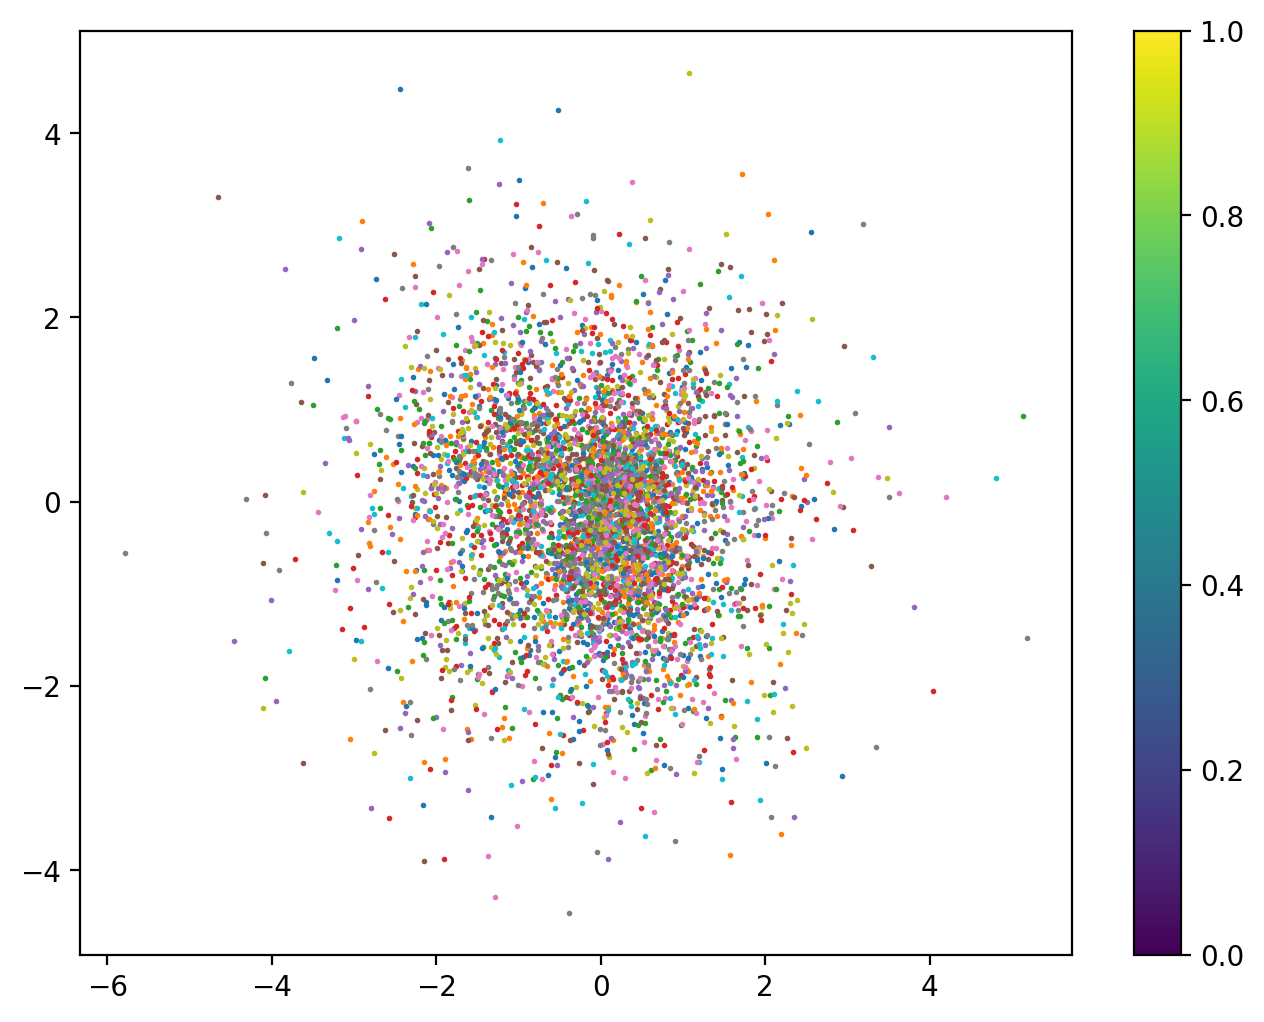

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import torch.distributions as dist
import torchvision
from torchvision import transforms
import numpy as np
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import os

plt.rcParams['figure.dpi'] = 200
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define a custom dataset class
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_files = [os.path.join(data_dir, file) for file in os.listdir(data_dir) if file.endswith('.jpg') or file.endswith('.png')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, 0  

transform = transforms.Compose([
    transforms.Resize((28, 28)), 
    transforms.ToTensor()
])

# Load custom dataset
data = torch.utils.data.DataLoader(
    CustomDataset('C:/Users/hegde/Downloads/Dl assignment/val2017', transform=transform),
    batch_size=128,
    shuffle=True
)

class Encoder(nn.Module):
    def __init__(self, hidden_dim, device):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(3 * 28 * 28, 512) 
        self.fc2_mean = nn.Linear(512, hidden_dim)
        self.fc3_logvar = nn.Linear(512, hidden_dim)
        self.N = dist.Normal(0, 1)
        self.device = device

    def forward(self, x):
        x = torch.flatten(x, start_dim=1) 
        x = F.relu(self.fc1(x))
        mu = self.fc2_mean(x)
        logvar = self.fc3_logvar(x)
        sigma = torch.exp(0.5 * logvar)
        z = mu + sigma * self.N.sample(mu.shape).to(self.device)
        return z, mu, logvar

class Decoder(nn.Module):
    def __init__(self, hidden_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(hidden_dim, 512)
        self.fc2 = nn.Linear(512, 3 * 28 * 28)  

    def forward(self, z):
        h = F.relu(self.fc1(z))
        x_recon = torch.sigmoid(self.fc2(h))
        return x_recon.view(-1, 3, 28, 28)  

class VariationalAutoencoder(nn.Module):
    def __init__(self, hidden_dim, device):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = Encoder(hidden_dim, device)
        self.decoder = Decoder(hidden_dim)

    def forward(self, x):
        z, mu, logvar = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon, mu, logvar

def train_vae(autoencoder, data, epochs=200):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in tqdm(range(epochs)):
        for x, _ in data:
            x = x.to(device)  # GPU
            opt.zero_grad()
            x_recon, mu, logvar = autoencoder(x)
            recon_loss = ((x - x_recon) ** 2).sum()
            kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
            loss = recon_loss + kld_loss
            loss.backward()
            opt.step()
    return autoencoder

def plot_latent(autoencoder, data, num_batches=100):
    plt.figure(figsize=(8, 6))
    for i, (x, _) in enumerate(data):
        z, _, _ = autoencoder.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], s=1)
        if i >= num_batches:
            break
    plt.colorbar()
    plt.show()

latent_dims = 3
vae = VariationalAutoencoder(latent_dims, device).to(device)
for images, _ in data:
    print("Image batch size:", images.size())
    break  
vae = train_vae(vae, data)
plot_latent(vae, data)

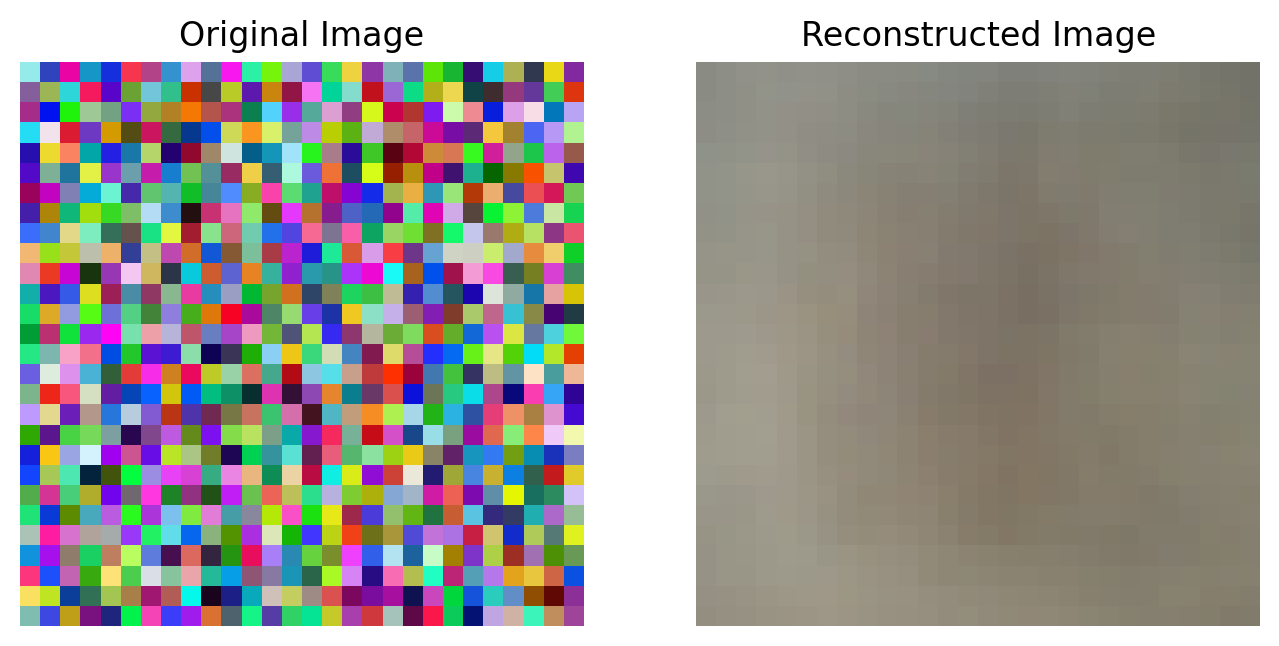

In [3]:
image = torch.rand(1, 3, 28, 28).to(device)  
vae.eval()  
with torch.no_grad():
    z, _, _ = vae.encoder(image)  
    reconstructed_image = vae.decoder(z)  
reconstructed_image = reconstructed_image.squeeze(0).cpu().numpy() 
reconstructed_image = np.transpose(reconstructed_image, (1, 2, 0))  
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(np.transpose(image.squeeze(0).cpu().numpy(), (1, 2, 0)))
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title("Reconstructed Image")
plt.imshow(reconstructed_image)
plt.axis('off')
plt.show()

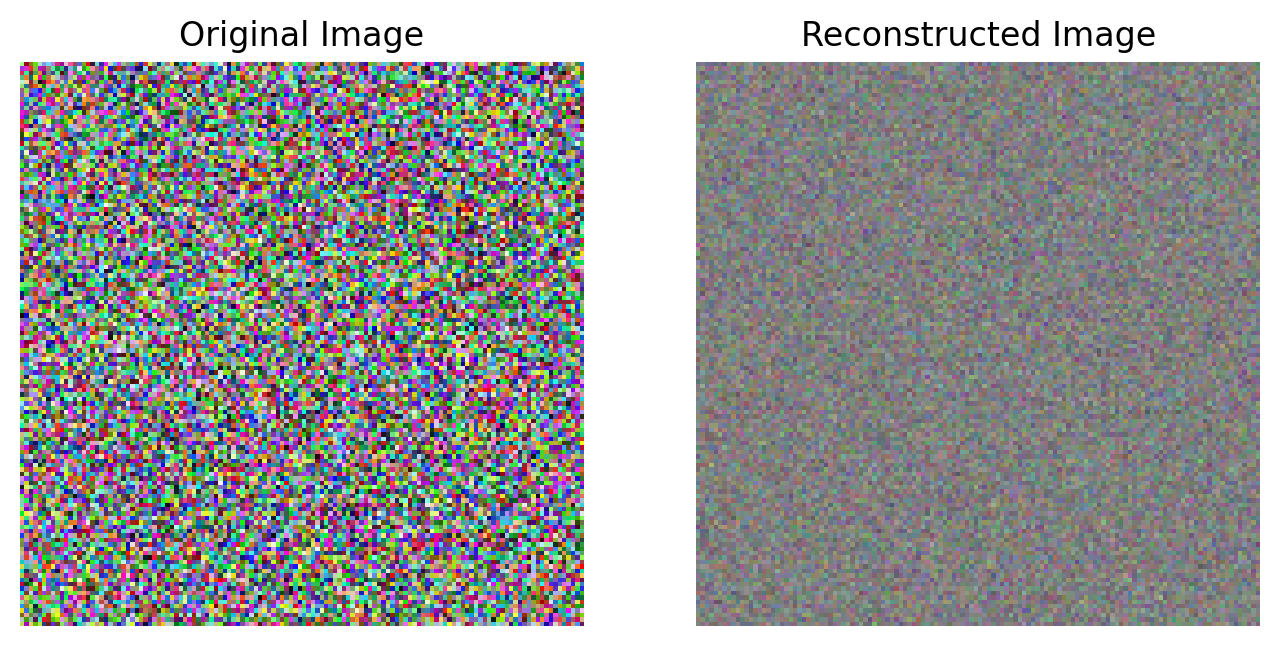

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import torch.distributions as dist
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['figure.dpi'] = 200
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

new_image_size = 128  # New image size (128x128)

class Encoder(nn.Module):
    def __init__(self, hidden_dim, device):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(3 * new_image_size * new_image_size, 2048)  # Adjust input size
        self.fc2_mean = nn.Linear(2048, hidden_dim)
        self.fc3_logvar = nn.Linear(2048, hidden_dim)
        self.N = dist.Normal(0, 1)
        self.device = device

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)  # Flatten the input
        x = F.relu(self.fc1(x))
        mu = self.fc2_mean(x)
        logvar = self.fc3_logvar(x)
        sigma = torch.exp(0.5 * logvar)
        z = mu + sigma * self.N.sample(mu.shape).to(self.device)
        return z, mu, logvar
class Decoder(nn.Module):
    def __init__(self, hidden_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(hidden_dim, 2048)
        self.fc2 = nn.Linear(2048, 3 * new_image_size * new_image_size) 

    def forward(self, z):
        h = F.relu(self.fc1(z))
        x_recon = torch.sigmoid(self.fc2(h))
        return x_recon.view(-1, 3, new_image_size, new_image_size) 
class VariationalAutoencoder(nn.Module):
    def __init__(self, hidden_dim, device):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = Encoder(hidden_dim, device)
        self.decoder = Decoder(hidden_dim)

    def forward(self, x):
        z, mu, logvar = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon, mu, logvar
latent_dims = 2
vae = VariationalAutoencoder(latent_dims, device).to(device)
image = torch.rand(1, 3, new_image_size, new_image_size).to(device) 

vae.eval()  
with torch.no_grad():
    z, _, _ = vae.encoder(image) 
    reconstructed_image = vae.decoder(z) 

reconstructed_image = reconstructed_image.squeeze(0).cpu().numpy()  
reconstructed_image = np.transpose(reconstructed_image, (1, 2, 0))  
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(np.transpose(image.squeeze(0).cpu().numpy(), (1, 2, 0)))
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title("Reconstructed Image")
plt.imshow(reconstructed_image)
plt.axis('off')
plt.show()

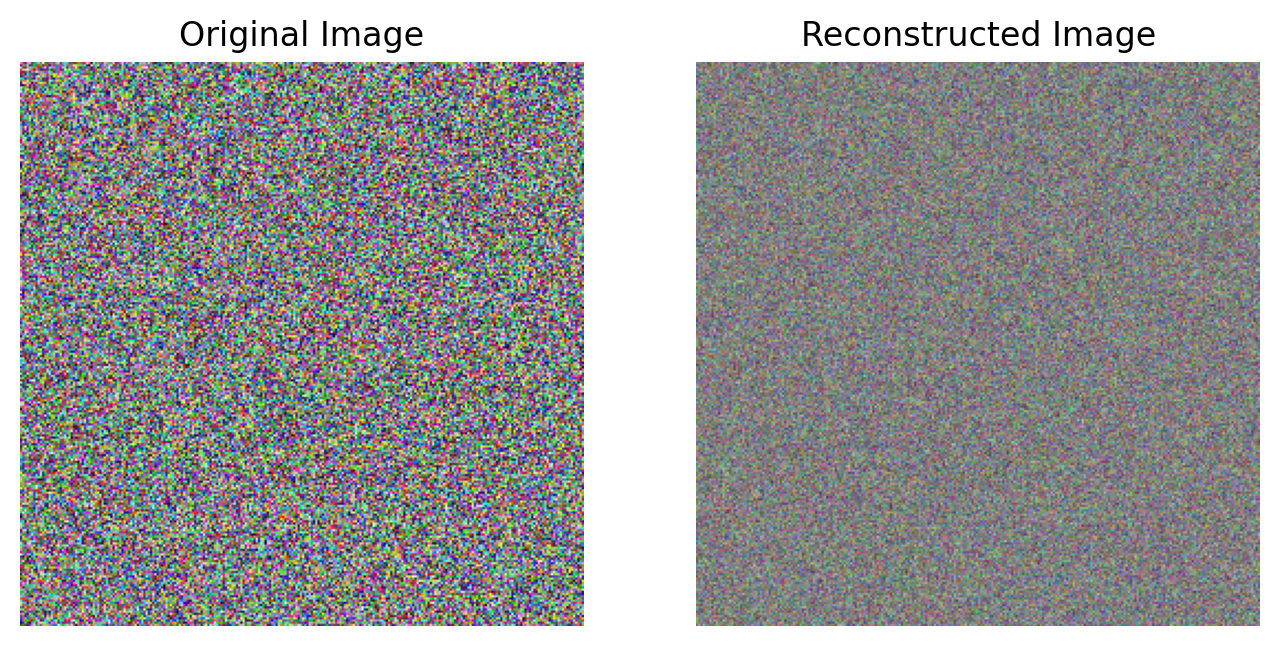

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import torch.distributions as dist
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['figure.dpi'] = 200
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
new_image_size = 256 
class Encoder(nn.Module):
    def __init__(self, hidden_dim, device):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(3 * new_image_size * new_image_size, 4096) 
        self.fc2_mean = nn.Linear(4096, hidden_dim)
        self.fc3_logvar = nn.Linear(4096, hidden_dim)
        self.N = dist.Normal(0, 1)
        self.device = device
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)  # Flatten the input
        x = F.relu(self.fc1(x))
        mu = self.fc2_mean(x)
        logvar = self.fc3_logvar(x)
        sigma = torch.exp(0.5 * logvar)
        z = mu + sigma * self.N.sample(mu.shape).to(self.device)
        return z, mu, logvar
class Decoder(nn.Module):
    def __init__(self, hidden_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(hidden_dim, 4096)
        self.fc2 = nn.Linear(4096, 3 * new_image_size * new_image_size)  
    def forward(self, z):
        h = F.relu(self.fc1(z))
        x_recon = torch.sigmoid(self.fc2(h))
        return x_recon.view(-1, 3, new_image_size, new_image_size) 
class VariationalAutoencoder(nn.Module):
    def __init__(self, hidden_dim, device):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = Encoder(hidden_dim, device)
        self.decoder = Decoder(hidden_dim)
    def forward(self, x):
        z, mu, logvar = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon, mu, logvar
latent_dims = 3
vae = VariationalAutoencoder(latent_dims, device).to(device)
image = torch.rand(1, 3, new_image_size, new_image_size).to(device) 
vae.eval() 
with torch.no_grad():
    z, _, _ = vae.encoder(image)  
    reconstructed_image = vae.decoder(z)  
reconstructed_image = reconstructed_image.squeeze(0).cpu().numpy()  
reconstructed_image = np.transpose(reconstructed_image, (1, 2, 0))  
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(np.transpose(image.squeeze(0).cpu().numpy(), (1, 2, 0)))
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title("Reconstructed Image")
plt.imshow(reconstructed_image)
plt.axis('off')
plt.show()